# The Lukewarm Hand, part 3


I decided to code up a simulation of what a "lukewarm" player might look like. How would that affect the distribution of z scores?

I'm not totally sure how to model it, because the whole idea is kind of ridiculous.

In [1]:
import streaky_players
import wald_wolfowitz
import streak_converter
import simulate_lukewarm

# the song of my people
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

## Gotta Start Somewhere

First, a really naive attempt. Each player will put up 900 shots a year, split across 60 games. I'm making the base shooting percentage 50%. If a player, call him Luke, has taken at least 8 attempts in the game, and made at least 80% of them, his shooting percentage goes down to 30%, and if he's missed at least 80% of them, his shooting percentage goes up to 70%.

In [2]:
def sim_season():
    GAMES = 60 # they miss some games, say
    SHOTS = 15 # this is actually pretty high for an average player, I think

    luke = streaky_players.LukewarmPlayer(shooting_percentage=.5)
    luke.MIN_ATTEMPTS = 8

    makes_misses = []
    for game in range(GAMES):
        for shot in range(SHOTS):
            makes_misses.append(luke.take_shot())
        luke.end_game()
    return pd.Series(makes_misses)

def handle_season(results):
    makes = sum(results > 0)
    misses = sum(results == 0)
    if (makes + misses) > 3:
        expected = wald_wolfowitz.get_expected_streaks(makes, misses)
        streak_data = streak_converter.convert_to_streaks(results)
        total_streaks = streak_data['total_streaks']
        variance = wald_wolfowitz.get_variance(makes, misses, expected)
        if variance > 0:
            z_score = (total_streaks - expected) / np.sqrt(variance)
            return (total_streaks, expected, variance, z_score)
        else:
            return None
    else:
        return None # not enough data!

def sim_multiple(num_seasons):
    seasons_result = []
    for x in range(num_seasons):
        results = sim_season()
        stat_results = handle_season(results)
        seasons_result.append(stat_results)

    return seasons_result

I'm going to look at 5000 simulated players.

In [3]:
luke = sim_multiple(550)

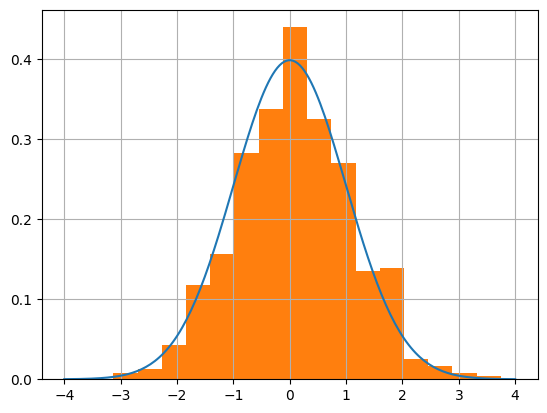

In [4]:
def summary_plot(sim):
    sim_summary = pd.DataFrame(sim, columns=["actual", "expected", "variance", "z_score"])
    x = np.linspace(-4,4,200)
    plt.plot(x, scipy.stats.norm.pdf(x, 0, 1))
    sim_summary.z_score.hist(bins=16, density=True)

    return sim_summary


luke_summary = summary_plot(luke)

In [5]:
luke_summary.z_score.describe()

count    550.000000
mean       0.089128
std        1.033592
min       -3.128572
25%       -0.598772
50%        0.087249
75%        0.754750
max        3.746083
Name: z_score, dtype: float64

as expected it did shift the mean to the right ("unstreaky" side), but didn't increase the standard deviation.

I should simulate a realistic season with the shooting percentages and number of attempts matching actual players.

In [6]:
import player_streaks
ps = player_streaks.PlayerStreaks()

actual_data = ps.get_data_with_stats()

In [7]:
df_season = pd.DataFrame({'attempts': actual_data.makes + actual_data.misses,
                          'shooting_percentage': actual_data.makes / (actual_data.makes + actual_data.misses)})

In [8]:
df_season

,attempts,shooting_percentage
player_id,,
1630173,327,0.501529
203500,167,0.544910
1628389,1113,0.485175
1630534,534,0.498127
1630583,648,0.483025
...,...,...
1629027,1376,0.411337
1627826,942,0.628450
1641783,483,0.412008


I will loop through df_season and simulate each one with lukewarmplayer. the problem is I don't have a realistic number of shots per game, because I didn't collect number of games played.

I found 4 attempts before the "unstreaky" behavior kicks in to produce pretty realistic results.

In [9]:
def sim_season_realistic(df):
    results = []
    for i, row in df.iterrows():
        sim_player = streaky_players.LukewarmPlayer(shooting_percentage=row.shooting_percentage)
        sim_player.MIN_ATTEMPTS = 4 # when streakiness kicks in. I don't know what number this should be.

        ### THIS IS A WILD ASS GUESS, I have no idea how shot attampts per game are distributed
        ### and should be using actual number of shots for each game.
        approx_games = 50
        approx_attempts = int(np.ceil(row.attempts/approx_games))
        makes_misses = []
        # like in the original research, I am concatenating game results
        # onto one long season-wide list
        for game in range(approx_games):
            for shot in range(approx_attempts):
                makes_misses.append(sim_player.take_shot())
            sim_player.end_game()
        season_stats = handle_season(pd.Series(makes_misses))
        if season_stats:
            results.append(season_stats)
    return results            

In [10]:
ssr = sim_season_realistic(df_season)

In [11]:
sim_summary = pd.DataFrame(ssr, columns=["actual", "expected", "variance", "z_score"])
    

In [12]:
sim_summary.z_score.describe()

count    554.000000
mean       0.218401
std        0.973750
min       -2.795960
25%       -0.361906
50%        0.202471
75%        0.854127
max        3.052713
Name: z_score, dtype: float64

For reference, here were the actual numbers from the 2024-5 season:


```
count    554.000000
mean       0.212491
std        1.075563
min       -3.081194
25%       -0.546340
50%        0.236554
75%        0.951653
max        3.054836
Name: z_score, dtype: float64

```

I don't think my model is really capturing the overdispersion. messing around with this simple sort of model hasn't 

ideas:


high volume shooters are extra unstreaky? (this is implicitly happening because the anti-streakiness doesn't kick in until 4+ shots)

unstreakiness works only in one direction? (don't get a boost when missing a lot, do get a penalty when making a lot)?

I want actual # of shots per each game (not just average). make sim as close as possible. sometimes role players will have 1 or 2 games where they shoot a bunch of shots

model a mixture of extra unstreaky and regular players?

## Looking at actual shot data
I'm not happy with the fact that I'm not following the actual number of shots per game.

I need complete shot data. If ound it downloadable from kaggle:

https://www.kaggle.com/datasets/mexwell/nba-shots

this is only up to 2023-24. the files are named after the 2nd year (2024) of the season rather than the first

In [13]:
shots =  pd.read_csv("kaggle_data/NBA_2024_Shots.csv")

In [14]:
shots.head()

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
0,2024,2023-24,1610612764,Washington Wizards,1629673,Jordan Poole,G,SG,11-03-2023,22300003,...,In The Paint (Non-RA),Center,C,8-16 ft.,-0.4,17.45,12,1,11,1
1,2024,2023-24,1610612764,Washington Wizards,1630166,Deni Avdija,F,SF,11-03-2023,22300003,...,Above the Break 3,Center,C,24+ ft.,1.5,30.55,25,1,10,26
2,2024,2023-24,1610612764,Washington Wizards,1626145,Tyus Jones,G,PG,11-03-2023,22300003,...,Restricted Area,Center,C,Less Than 8 ft.,-3.3,6.55,3,1,9,46
3,2024,2023-24,1610612764,Washington Wizards,1629673,Jordan Poole,G,SG,11-03-2023,22300003,...,Restricted Area,Center,C,Less Than 8 ft.,-1.0,5.85,1,1,8,30
4,2024,2023-24,1610612764,Washington Wizards,1626145,Tyus Jones,G,PG,11-03-2023,22300003,...,Restricted Area,Center,C,Less Than 8 ft.,-0.0,6.25,1,1,8,8


this takes a couple of minutes to run. the streak_converter is probably a part of the problem

In [15]:

combined_df = pd.DataFrame(columns=["player_id", "game_id", "makes", 
                                "misses", "total_streaks", "raw_data"])
combined_df = combined_df.set_index(["player_id", "game_id"])


for key, results in shots.groupby(["PLAYER_ID", "GAME_ID"])["SHOT_MADE"]:
    streak_data = "".join(results.replace(True, "W").replace(False, "L"))
    as_streaks = streak_converter.convert_to_streaks(False, streak_data)

    combined_df.loc[key, :] = [as_streaks['makes'], as_streaks['misses'],
                                  as_streaks['total_streaks'], as_streaks['raw_data']
                                ]

In [16]:
#combined_df.to_pickle("caseytestingstuff.pkl")

In [17]:
combined_df['expected_streaks'] = wald_wolfowitz.get_expected_streaks(combined_df.makes, combined_df.misses)

In [18]:
combined_df

makes misses total_streaks                raw_data  \
player_id game_id                                                       
2544      22300015    11      6             9       LWLWLWWWWWWWLLWWL   
          22300026     6      5             5             WWLWLLLLWWW   
          22300036    13      9            16  WLWWLWLWWWLWWLWLWWLLWL   
          22300042     6      4             7              WLWLLWWWLW   
          22300061    10      6            11        WLWLLWWLWWLWWWLW   
...                  ...    ...           ...                     ...   
1642013   22301108     0      7             1                 LLLLLLL   
          22301146     3      5             4                WLLWWLLL   
          22301160     3      7             5              LLLWWLLWLL   
          22301176     0      2             1                      LL   
          22301189     3      4             5                 WLWLLLW   

                   expected_streaks  
player_id game_id                    
2544      22300015         8.764706  
          22300026         6.454545  
          22300036        11.636364  
          22300042              5.8  
          22300061              8.5  
...                             ...  
1642013   22301108              1.0  
          22301146             4.75  
          22301160              5.2  
          22301176              1.0  
          22301189         4.428571  

[24895 rows x 5 columns]

here's evidence of un-streaky behavior at the game-by-game level. there are a lot more player-game combos with too many streaks than too few streaks.

In [19]:
streak_diff = combined_df.total_streaks - combined_df.expected_streaks

In [20]:
sum(streak_diff > 0)

10285

In [21]:
sum(streak_diff < 0)

8977

In [22]:
sum(streak_diff == 0)

5633

we'd expect there to be as many streaks with negative z scores as positive ones. The imbalance is significant. (I don't think chi square is the right test with such large numbers)

In [23]:
scipy.stats.chisquare([10285, 8977])


Power_divergenceResult(statistic=np.float64(88.8206832104662), pvalue=np.float64(4.322725746451667e-21))

In [62]:
10285 / (10285 + 8977)

0.5339528605544596

In [63]:
10285 - np.mean([10285, 8977])

np.float64(654.0)

## Game-level z scores

have to redo some previous ETL here with the new data.

In [24]:
# have to drop ones where variance is zero/undefined -- 3 shots or fewer

clean_df = combined_df[(combined_df.makes + combined_df.misses) > 3].copy()
clean_df['variance'] = wald_wolfowitz.get_variance(clean_df.makes, 
                                                      clean_df.misses, 
                                                      clean_df.expected_streaks)
clean_df = clean_df[clean_df.variance > 0].copy() # to prevent divide by zero below

In [25]:
clean_df.head()

makes misses total_streaks                raw_data  \
player_id game_id                                                       
2544      22300015    11      6             9       LWLWLWWWWWWWLLWWL   
          22300026     6      5             5             WWLWLLLLWWW   
          22300036    13      9            16  WLWWLWLWWWLWWLWLWWLLWL   
          22300042     6      4             7              WLWLLWWWLW   
          22300061    10      6            11        WLWLLWWLWWLWWWLW   

                   expected_streaks  variance  
player_id game_id                              
2544      22300015         8.764706  3.282872  
          22300026         6.454545  2.429752  
          22300036        11.636364  4.880756  
          22300042              5.8  2.026667  
          22300061              8.5      3.25

## Corrections & small sample sizes

Because these are small sample sizes, and we're comparing an integer value (actual number of runs) with a value from a continuous probability distribution (theoretical number of runs) one *could* do a continuity correction here.


The way the [SAS version of the test](https://support.sas.com/kb/33/092.html) does it, when sample size is less than 50, when calculating z-score: 

* if actual - theoretical < 0, adds .5 to numerator
* if actual - theoretical > 0, subtracts .5 from numerator

 For a hypothesis test on a small sample, the correct thing to do would be use a lookup table where someone has calculated the exact probabilities.  https://webspace.ship.edu/pgmarr/Geo441/Tables/Runs%20Table.pdf 


For the sake of thoroughness, I worked it out below. I don't think it's appropriate for my purposes. I'm not doing a hypothesis test on one individual player's record in one game, I'm looking at the distribution of 20,000 of them. The z-scores with the continuity correction are clearly not normal, as shown below, and the scores without it clearly are normal.

A bit further along, I show how to calculate the exact probabilities of each possible streak length.

In [26]:
clean_df.loc[clean_df.total_streaks < clean_df.expected_streaks, 'z_score_cc'] = (clean_df.total_streaks - clean_df.expected_streaks + .5) / ((clean_df.variance)**.5)
clean_df.loc[clean_df.total_streaks >= clean_df.expected_streaks, 'z_score_cc'] = (clean_df.total_streaks - clean_df.expected_streaks - .5) / ((clean_df.variance)**.5)


In [27]:
clean_df['z_score'] = (clean_df.total_streaks - clean_df.expected_streaks) / ((clean_df.variance)**.5)

In [28]:

def plot_z(z_plot, title="individual game z-scores, 2023-24 season"):
    x = np.linspace(-3,3,200)
    plt.plot(x, scipy.stats.norm.pdf(x, 0, 1))

    out = plt.hist(z_plot, bins=np.arange(-3,3,.5), density=True)
    plt.title(title)

this is the distribution with continuity correction, which is clearly ridiculous

In [29]:
clean_df.z_score_cc.astype("float").describe()

count    18982.000000
mean        -0.031954
std          0.687916
min         -3.047828
25%         -0.401101
50%          0.000000
75%          0.302765
max          3.390395
Name: z_score_cc, dtype: float64

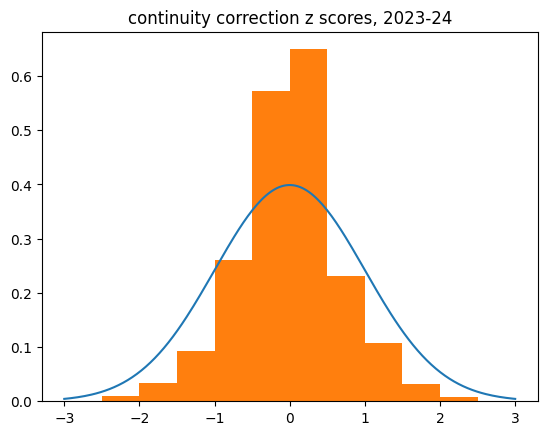

In [30]:
plot_z(clean_df.z_score_cc, "continuity correction z scores, 2023-24")

### On fairness
I could instead calculate number of streaks expected for a player who shoots x% from the field...

say a player who is usually a 50% shooter takes 8 shots in a game and makes all 8.

the player didn't miss any shots, so we'd expect only 1 streak.

however, if they went 4 for 8 like a usual night, we'd expect `4 + 1 = 5` streaks.

using the same # of makes/misses as the real game is a stricter way to define it (and fairer, if you don't buy the *Lukewarm Hand*)

It's throwing out intra-game streakiness in a way. It's modeling the idea that one day, a shooter really is a 60% shooter and the next day they really are a 20% shooter, rather than being a 40% shooter both days.

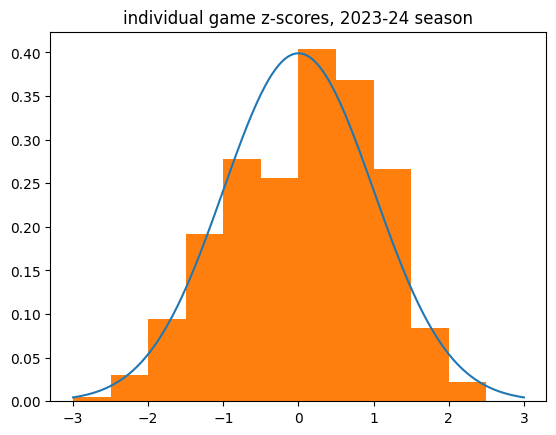

In [31]:
z_plot = clean_df.z_score.astype("float")

plot_z(z_plot)

In [32]:
z_plot.describe()

count    18982.000000
mean         0.051765
std          0.988789
min         -3.332292
25%         -0.707107
50%          0.104103
75%          0.816497
max          3.583243
Name: z_score, dtype: float64

although the mean is small, the sample size is large, so it is significant

In [2]:
.051765 / (.988789 / np.sqrt(18982))

NameError: name 'np' is not defined

### Big Games Only

I think there are probably a lot of games where number of expected streaks is only 1 or 2. what about higher number expected?

In [34]:
sum(clean_df.expected_streaks < 10)

17142

In [35]:
sum(clean_df.expected_streaks >= 10)

1840

In [36]:
big_games = clean_df[(clean_df.makes > 10) | (clean_df.misses > 10)].z_score.astype("float")

There are around 2500 player-games where there were at least 10 makes or misses by the player.

In [37]:
big_games.describe()

count    2536.000000
mean        0.055925
std         1.010195
min        -3.079575
25%        -0.616678
50%         0.072404
75%         0.750366
max         3.583243
Name: z_score, dtype: float64

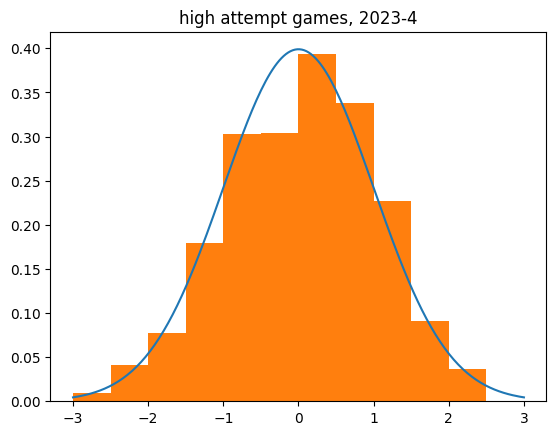

In [38]:
plot_z(big_games, title="high attempt games, 2023-4")

In [39]:
sum(big_games > 0)

1333

In [40]:
sum(big_games < 0)

1154

In [41]:
scipy.stats.chisquare([1333, 1154])

Power_divergenceResult(statistic=np.float64(12.883393646964214), pvalue=np.float64(0.00033151055973599483))

### Is the Wald-Wolfowitz test "fair"?

Yeah, it is. The estimate of the mean is the exact expected

Say we've got 7 makes and 4 misses. The W-W test says there will be 6.0909... streaks. It's not a whole number because it's not returning the *most likely* number of streaks (which probably would be 6), it's returning the *exact* mean number of streaks.

In [42]:
expected_streaks = wald_wolfowitz.get_expected_streaks(7,4)

expected_streaks

6.090909090909091

We can calculate the *exact* probabilities of each number of streaks, conditioned on the fact that there are 7 wins and 4 losses. each possible sequence of wins and losses in that set are equally likely, assuming no funny business.

In [43]:
# loop through all possible combinations of 7 wins, 4 losses
# calculate the number of streaks for EVERY combination

# unlike the normal approx of the wald-wolfowitz test, this will give the EXACT probabilities
# of each streak length (assuming the order of the makes/misses are independent)
import itertools
import math

def generate_exact_df(wins, losses):
    to_permute = ([0] * wins) + ([1] * losses)

    # I don't know why itertools doesn't have a "distinct permutations" function
    perms = set()
    for x in itertools.permutations(to_permute, wins+losses):
        perms.add(x)

    expected_perms = math.factorial(wins+losses)  / (math.factorial(wins) * math.factorial(losses))
    assert len(perms) == expected_perms, "I forgot how to do math!"

    exact_df = pd.DataFrame(columns=["zeroes", "ones", "streaks", "as_str"])
    for x in list(perms):
        perm = pd.Series(x)
        streak_data = streak_converter.convert_to_streaks(perm)
        exact_df.loc[len(exact_df)]  = [streak_data['misses'], streak_data['makes'], 
                            streak_data['total_streaks'], "".join(perm.replace(0, "0").replace(1, "1"))]
    return exact_df

exact_df = generate_exact_df(7,4)

In [44]:
exact_df

,zeroes,ones,streaks,as_str
0,7,4,6,00100001101
1,7,4,5,10000001101
2,7,4,7,00010010110
3,7,4,7,00011001010
4,7,4,8,00010100101
...,...,...,...,...
325,7,4,7,00010011010
326,7,4,4,00000010111
327,7,4,5,10000011001
328,7,4,6,00100001011


In [1]:
exact_df.streaks.hist()

NameError: name 'exact_df' is not defined

In [45]:
exact_df.streaks.describe()

count    330.000000
mean       6.090909
std        1.445329
min        2.000000
25%        5.000000
50%        6.000000
75%        7.000000
max        9.000000
Name: streaks, dtype: float64

The actual standard deviation (above) is very very close to the theoretical value.

In [46]:
np.sqrt(wald_wolfowitz.get_variance(7,4,expected_streaks))

np.float64(1.443137078762504)

It doesn't look normal. it's definitely not symmetric. it looks more like a binomial distribution.

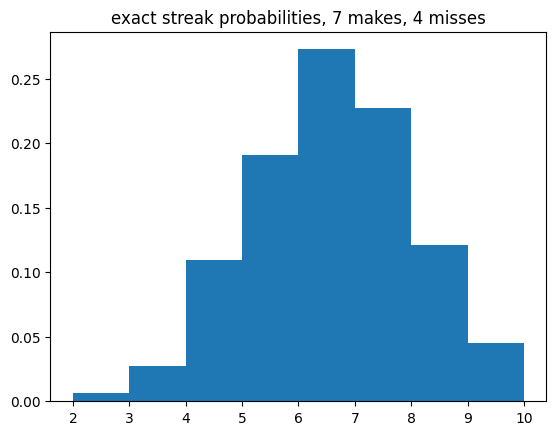

In [47]:
exact_hist = plt.hist(exact_df.streaks, density=True, bins=[2,3,4,5,6,7,8,9,10])
_trash = plt.title("exact streak probabilities, 7 makes, 4 misses")

Individual games are very small sample sizes. But we should see a very similar distribution as the above if we look at actual player games with 7 makes and 4 misses.

And we do!

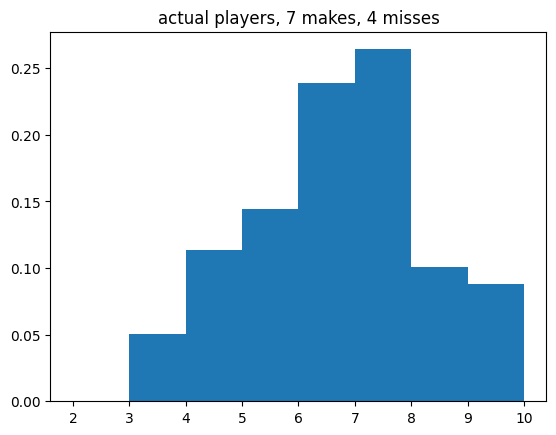

In [48]:
actual_streaks = clean_df[(clean_df.makes == 7) & (clean_df.misses ==4)].total_streaks.astype("float")

actual_hist = plt.hist(actual_streaks, bins=range(2,11), density=True)

_trash = plt.title("actual players, 7 makes, 4 misses")

here are the two histograms on top of each other. Orange is where there were more actual streaks, blue where there were more theoretical streaks, and brown is where they overlap.

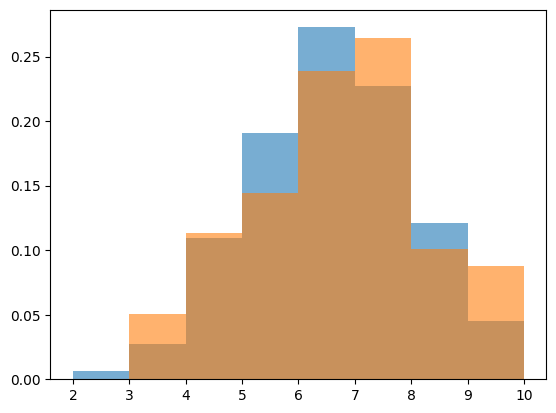

In [49]:
_trash = plt.hist(exact_df.streaks, density=True, bins=range(2,11), alpha=0.6)
_trash = plt.hist(actual_streaks, bins=range(2,11), density=True, alpha=0.6)

the above kinda look like a binomial distribution, but it's not, for several important reasons, starting with binomial including nonzero probabilities for 0,1, and 10, which are impossible streak lengths here.

<BarContainer object of 11 artists>

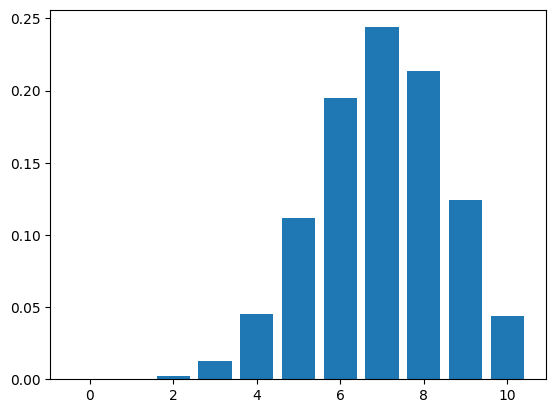

In [ ]:
binom_example = scipy.stats.binom(11, 7/11)

binom_example_df = pd.DataFrame({
    'x': [x for x in range(0,11)],
    'y': [binom_example.pmf(x) for x in range(0,11)]

})
plt.bar(binom_example_df.x, binom_example_df.y)

the exact distribution is worked out here: [https://online.stat.psu.edu/stat415/lesson/21/21.1](https://online.stat.psu.edu/stat415/lesson/21/21.1)

Here are the probability mass functions for even and odd numbers of streaks:

$P(R=2k)=\dfrac{2\binom{n_1-1}{k-1}\binom{n_2-1}{k-1}}{\binom{n_1+n_2}{n_1}}$

$P(R=2k+1)=\dfrac{\binom{n_1-1}{k}\binom{n_2-1}{k-1}+\binom{n_2-1}{k}\binom{n_1-1}{k-1}}{\binom{n_1+n_2}{n_1}}$

I could go back and calculate the exact probabilities for game level stats... maybe I will in a future installment

## Back to simulation

OK, now that I have actual shot data, I can make the lukewarm player simulation more realistic. Unlike the tests above, I'm not going to match the player's exact number of makes and misses. The point is to simulate the streaky behavior. that means that a player's FG% in the simulation will probably be different than it was in real life. 

The system will simulate each shot taken in the NBA at the player's end of season FG%.

pulled the code into its own class...

In [51]:
better_simulation = simulate_lukewarm.SimulateLukewarm(clean_df)
sim_summary2 = better_simulation.sim_season()

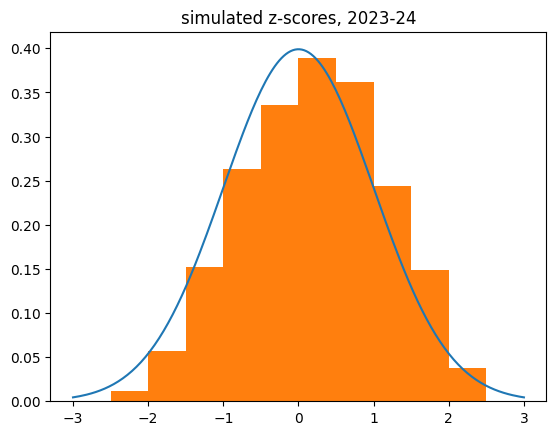

In [52]:
plot_z(sim_summary2.z_score, "simulated z-scores, 2023-24")

In [53]:
sim_summary2.z_score.describe()

count    525.000000
mean       0.207116
std        0.954888
min       -2.129829
25%       -0.473728
50%        0.236694
75%        0.908465
max        2.430476
Name: z_score, dtype: float64

wow! that's remarkably similar to the 2024-25 season, but what about 2023-24?

In [54]:
import player_streaks

sp = player_streaks.PlayerStreaks(season="2023-24")
prev_year_df = sp.get_data_with_stats()

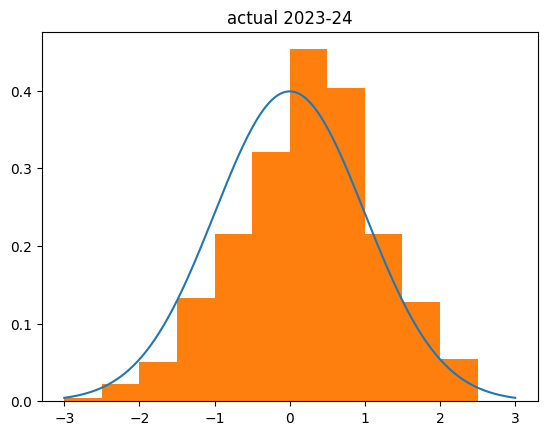

In [55]:
plot_z(prev_year_df.z_score, "actual 2023-24")

unfortunately, this code will only get the shots from last season, for players who were active *this* season. I'll leave redoing that code as an exercise for the reader...

In [56]:
prev_year_df.z_score.describe()

count    446.000000
mean       0.290885
std        0.999102
min       -2.982421
25%       -0.335842
50%        0.326163
75%        0.919764
max        3.086872
Name: z_score, dtype: float64

## What about streakiness in only one direction?

It just looks like a toned-down version of the previous simulation, even when I increased the amount of penalty when a player's on a hot streak and boost when a player's on a cold streak.

In [57]:
heat_check_sim = simulate_lukewarm.SimulateLukewarm(clean_df)
heat_check_sim.player_type = streaky_players.OnlyHeatCheckPlayer


heat_check_summary = heat_check_sim.sim_season()
heat_check_summary.z_score.describe()

count    530.000000
mean       0.128552
std        0.973237
min       -3.158805
25%       -0.573747
50%        0.147804
75%        0.767398
max        2.602529
Name: z_score, dtype: float64

In [58]:
get_bucket_sim = simulate_lukewarm.SimulateLukewarm(clean_df)
get_bucket_sim.player_type = streaky_players.GetABucketPlayer

bucket_summary = get_bucket_sim.sim_season()
bucket_summary.z_score.describe()

count    526.000000
mean       0.144055
std        0.975503
min       -2.592224
25%       -0.557261
50%        0.164444
75%        0.814466
max        2.840975
Name: z_score, dtype: float64

## What about a mixture of streaky and non-streaky?

I will have to come back to that.

## What would truly streaky players look like?
(gen actual box scores? look at streak lengths?)

In [59]:
from importlib import reload
reload(streaky_players)

<module 'streaky_players' from 'c:\\code\\hot_hand\\streaky_players.py'>

In [60]:
truly_streaky_sim = simulate_lukewarm.SimulateLukewarm(clean_df)
truly_streaky_sim.player_type = streaky_players.TrulyStreakyPlayer

truly_summary = truly_streaky_sim.sim_season()
truly_summary.z_score.describe()

count    524.000000
mean      -0.455522
std        1.144570
min       -4.413268
25%       -1.225128
50%       -0.458503
75%        0.404549
max        2.486584
Name: z_score, dtype: float64

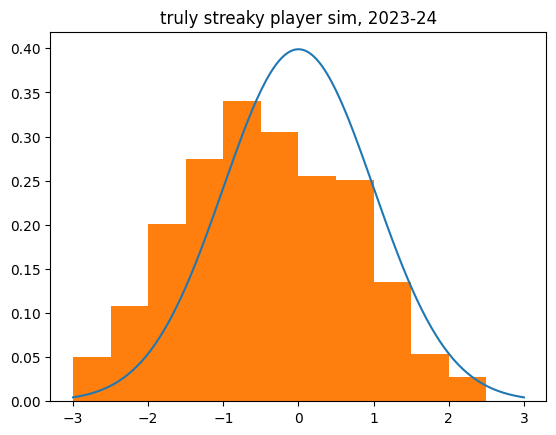

In [61]:
plot_z(truly_summary.z_score, title="truly streaky player sim, 2023-24")

## What about sims on sims on sims?

Cut for time